In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# --- Environment Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Data Preprocessing (CIFAR-10) ---
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- Helper Functions ---
def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.float().to(device)  # ✅ Corrected
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return train_losses

def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.float().to(device)  # ✅ Corrected
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    mse = total_loss / len(loader)
    print(f"Test MSE: {mse:.4f}")
    return mse

In [10]:
# --- Model Definitions ---

## 1️⃣ Linear Regression Model
class SimpleLinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

## 2️⃣ Linear Regression with L1 & L2 Regularization
def l1_l2_loss(output, target, model, l1_lambda=0.0, l2_lambda=0.0):
    mse = nn.MSELoss()(output, target)
    l1 = sum(param.abs().sum() for param in model.parameters())
    l2 = sum(param.pow(2).sum() for param in model.parameters())
    return mse + l1_lambda * l1 + l2_lambda * l2

## 3️⃣ Transfer Learning Model (Feature Extraction)
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in base_model.parameters():
            param.requires_grad = False
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        self.regressor = nn.Linear(base_model.fc.in_features, 1)

    def forward(self, x):
        features = self.backbone(x).view(x.size(0), -1)
        return self.regressor(features)

In [11]:
# --- Training & Evaluation ---

## 1️⃣ Linear Regression (No Regularization)
print("\n--- Linear Regression ---")
input_dim = 64 * 64 * 3
lr_model = SimpleLinearRegression(input_dim).to(device)
lr_optimizer = optim.Adam(lr_model.parameters(), lr=0.001)
lr_criterion = nn.MSELoss()

lr_losses = train_model(lr_model, train_loader, lr_optimizer, lr_criterion)
lr_mse = evaluate_model(lr_model, test_loader, lr_criterion)

## 2️⃣ Linear Regression with L1 and L2 Regularization
print("\n--- Linear Regression with L1 & L2 Regularization ---")
l1_lambda, l2_lambda = 0.001, 0.001
l1_l2_model = SimpleLinearRegression(input_dim).to(device)
l1_l2_optimizer = optim.Adam(l1_l2_model.parameters(), lr=0.001)

def train_with_regularization(model, loader, optimizer, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.float().to(device)  # ✅ Corrected
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = l1_l2_loss(outputs, targets, model, l1_lambda, l2_lambda)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

l1_l2_losses = train_with_regularization(l1_l2_model, train_loader, l1_l2_optimizer)
l1_l2_mse = evaluate_model(l1_l2_model, test_loader, lr_criterion)


--- Linear Regression ---
Epoch 1/5, Loss: 9.6693
Epoch 2/5, Loss: 9.5918
Epoch 3/5, Loss: 9.2728
Epoch 4/5, Loss: 9.1486
Epoch 5/5, Loss: 9.1521
Test MSE: 8.2602

--- Linear Regression with L1 & L2 Regularization ---
Epoch 1/5, Loss: 9.8180
Epoch 2/5, Loss: 9.4398
Epoch 3/5, Loss: 9.3606
Epoch 4/5, Loss: 9.6686
Epoch 5/5, Loss: 9.0183
Test MSE: 8.2600


In [12]:
## 3️⃣ Transfer Learning with Feature Extraction
print("\n--- Transfer Learning ---")
tl_model = TransferLearningModel().to(device)
tl_optimizer = optim.Adam(tl_model.regressor.parameters(), lr=0.001)
tl_criterion = nn.MSELoss()

tl_losses = train_model(tl_model, train_loader, tl_optimizer, tl_criterion)
tl_mse = evaluate_model(tl_model, test_loader, tl_criterion)


--- Transfer Learning ---
Epoch 1/5, Loss: 7.6267
Epoch 2/5, Loss: 6.9146
Epoch 3/5, Loss: 6.8417
Epoch 4/5, Loss: 6.7861
Epoch 5/5, Loss: 6.7615
Test MSE: 6.8008


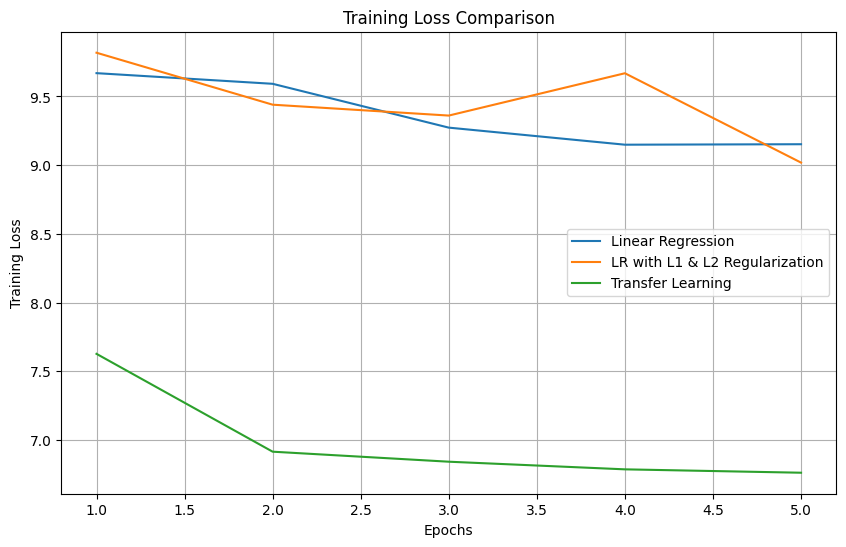


✅ Final Test MSEs:
Linear Regression: 8.2602
LR with L1 & L2 Regularization: 8.2600
Transfer Learning: 6.8008


In [13]:
# --- Visualization ---
epochs = range(1, 6)
plt.figure(figsize=(10, 6))
plt.plot(epochs, lr_losses, label="Linear Regression")
plt.plot(epochs, l1_l2_losses, label="LR with L1 & L2 Regularization")
plt.plot(epochs, tl_losses, label="Transfer Learning")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Final Results ---
print("\n✅ Final Test MSEs:")
print(f"Linear Regression: {lr_mse:.4f}")
print(f"LR with L1 & L2 Regularization: {l1_l2_mse:.4f}")
print(f"Transfer Learning: {tl_mse:.4f}")